<a href="https://colab.research.google.com/github/AnIsAsPe/Aprendizaje-por-Refuerzo/blob/main/Gesti%C3%B3n_de_una_red_el%C3%A9ctrica_mediante_Aprendizaje_por_refuerzo_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalar [pymgrid](https://github.com/Total-RD/pymgrid) y cargar bibliotecas


In [1]:
!pip install git+https://github.com/Total-RD/pymgrid/

  Cloning https://github.com/Total-RD/pymgrid/ to /tmp/pip-req-build-jhp5l46y
  Running command git clone -q https://github.com/Total-RD/pymgrid/ /tmp/pip-req-build-jhp5l46y
  Created wheel for pymgrid: filename=pymgrid-0.1.0-cp37-none-any.whl size=3423628 sha256=5d2b0579cf2c84522e6472619c09dac240fd48ca7645fcb782ccf2735ce6b68a
  Stored in directory: /tmp/pip-ephem-wheel-cache-uuzb0ar9/wheels/b9/cd/f9/5ebf7c874ff90d3fa2c288536524ec639b3aa2be1af92d6fb7
Successfully built pymgrid


In [2]:

from pymgrid import MicrogridGenerator as mg

# para generar un ambiente en OpenAI Gym
#from pymgrid.Environments.pymgrid_cspla import MicroGridEnv 

import numpy as np
import matplotlib.pyplot as plt

import os
import time
import sys

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# El Problema

## Red eléctirca "El Espino"

---
![microgrid Espino](https://ars.els-cdn.com/content/image/1-s2.0-S0360544219317682-gr4.jpg)

---

**Objetivo:**

 Optimizar el ***costo*** de la red frente a la incertidumbre la generación de energía solar y de la demanda de energía

**Alternativas:**

1. Operar la red con reglas:

    - Priorizar consumo de la energía solar
    - Si la generación fotovoltaica es mayor que la demanda, se carga la batería
    - Si la energía solar no alcanza a satisfacer el consumo, se descarrga la batería hasta que alcance el 50% de la carga
    - Si la energía solar y la batería no alcanzan a satisfacer la demanda, se prende el generador de gas
    - El generador carga la batería si la demanda es menor que la generación minima de operación.

2. Aprender una ***política*** para decidir una acciones dado un estado

Necesitamos definir las ***acciones posibles*** y los ***estados posibles*** y realizar un proceso de aprendizaje de la política





## Estados, acciones, recompensa/pérdida



**Acciones posibles:**

- Generar energía con gas
- Descargar batería para usar energía almacenada
- Cargar batería (almacenar exceso de energía)

**Estados posibles:**

- Demanda Neta:  Demanda de energía - Generación de energía solar
- Estado de carga de la Batería


**Recompensa/pérdida**
- Costo de generación de electricidad

# Selección de una arquitectura de la microrred utilizando pymgrid

In [3]:
env = mg.MicrogridGenerator(nb_microgrid=6, random_seed = 7) 
env.generate_microgrid(verbose=True)  #verbose=True despliega la capacidad y costos de cada red



print('\nArquitectura de cada red generada:\n'.upper())
for i in range(env.nb_microgrids):
    print("Microred {}: {}".format(int(i), str(env.microgrids[i].architecture)))

,load,cost_loss_load,cost_overgeneration,cost_co2,PV_rated_power,battery_soc_0,battery_power_charge,battery_power_discharge,battery_capacity,battery_efficiency,battery_soc_min,battery_soc_max,battery_cost_cycle,genset_polynom_order,genset_polynom_0,genset_polynom_1,genset_polynom_2,genset_rated_power,genset_pmin,genset_pmax,fuel_cost,genset_co2,grid_weak,grid_power_import,grid_power_export
0,49789,10,1,0.1,56261.57,0.2,27220,27220,108877,0.9,0.2,1,0.02,3.0,0.720511,0.268439,0.049988,55322.0,0.05,0.9,0.4,2.0,NaN,NaN,NaN
1,89104,10,1,0.1,93559.20,1.0,45891,45891,183561,0.9,0.2,1,0.02,3.0,4.521240,0.931206,0.002490,99005.0,0.05,0.9,0.4,2.0,0.0,178208.0,178208.0
2,29062,10,1,0.1,29933.86,0.2,14968,14968,59870,0.9,0.2,1,0.02,3.0,0.076550,0.138980,0.005966,32292.0,0.05,0.9,0.4,2.0,1.0,58124.0,58124.0
3,35286,10,1,0.1,41284.62,1.0,14457,14457,57825,0.9,0.2,1,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,70572.0,70572.0
4,44890,10,1,0.1,27382.90,0.2,18391,18391,73563,0.9,0.2,1,0.02,3.0,6.157783,0.944599,0.032755,49878.0,0.05,0.9,0.4,2.0,1.0,89780.0,89780.0
5,1935,10,1,0.1,1470.60,0.2,1220,1220,4877,0.9,0.2,1,0.02,3.0,6.913058,0.361482,0.065401,2150.0,0.05,0.9,0.4,2.0,NaN,NaN,NaN



ARQUITECTURA DE CADA RED GENERADA:

Microred 0: {'PV': 1, 'battery': 1, 'genset': 1, 'grid': 0}
Microred 1: {'PV': 1, 'battery': 1, 'genset': 1, 'grid': 1}
Microred 2: {'PV': 1, 'battery': 1, 'genset': 1, 'grid': 1}
Microred 3: {'PV': 1, 'battery': 1, 'genset': 0, 'grid': 1}
Microred 4: {'PV': 1, 'battery': 1, 'genset': 1, 'grid': 1}
Microred 5: {'PV': 1, 'battery': 1, 'genset': 1, 'grid': 0}


In [4]:
# seleccionamos un ambiente con un arquitectura conveniente para nuestro problema
red = env.microgrids[5]
print(red.architecture)

{'PV': 1, 'battery': 1, 'genset': 1, 'grid': 0}


## Las series de tiempo de demanda energética y generación solar
Con pymgrid, la red generada, además de una arquitectura, y la capacidad de los elementos de la red, es asociada a dos series de tiempo con  datos históricos de de demanda energética y de  generación  de energía.

Cada observación es una hora y la longitud de la serie es de un año (8769 horas)

In [5]:
red.print_load_pv()

Load


PV


In [6]:
red.print_info()

Microgrid parameters


,load,cost_loss_load,cost_overgeneration,cost_co2,PV_rated_power,battery_soc_0,battery_power_charge,battery_power_discharge,battery_capacity,battery_efficiency,battery_soc_min,battery_soc_max,battery_cost_cycle,genset_polynom_order,genset_polynom_0,genset_polynom_1,genset_polynom_2,genset_rated_power,genset_pmin,genset_pmax,fuel_cost,genset_co2
0,1935,10,1,0.1,1470.6,0.2,1220,1220,4877,0.9,0.2,1,0.02,3,6.913058,0.361482,0.065401,2150,0.05,0.9,0.4,2


Architecture:
{'PV': 1, 'battery': 1, 'genset': 1, 'grid': 0}
Actions: 
dict_keys(['load', 'pv_consummed', 'pv_curtailed', 'pv', 'battery_charge', 'battery_discharge', 'genset'])
Control dictionnary:
['load', 'pv_consummed', 'pv_curtailed', 'pv', 'battery_charge', 'battery_discharge', 'genset']
Status: 
dict_keys(['load', 'hour', 'pv', 'battery_soc', 'capa_to_charge', 'capa_to_discharge'])
Has run mpc baseline:
False
Has run rule based baseline:
False


# Características de los componentes


### **Demanda**

In [7]:
red.load   # variable aleatoria en función del tiempo

613.563907279512

### **Generación fotovoltaica (pv)**

In [8]:
red.pv # variable aleatoria en función del tiempo

0.0

### **Batería**

In [9]:
# Cantidad de energía que la batería puede cargar antes de tener carga completa
red.battery.capa_to_charge  

4335.1

In [10]:
 # Cantidad de energía disponible antes de estar totalmente descargada
red.battery.capa_to_discharge  

0.0

In [11]:
## Cantidad de energía máxima que puede cargar la batería en una hora
red.battery.p_charge_max


1220

In [12]:
# Cantidad de energía máxima que puede descargar la batería en una hora
red.battery.p_discharge_max

1220

In [13]:
#Estado de la carga
red.battery.soc

0.2

In [14]:
#Estado de carga máxima
red.battery.soc_max

1

In [15]:
#Estado de carga mínima
red.battery.soc_min

0.2

In [16]:
#Eficiencia de la batería
red.battery.efficiency

0.9

### **Generador de combustibles fósiles (genset)**

In [17]:
# Características del generador

print('Potencia máxima del generador en KW: ', red.genset.rated_power )

print('Costo del combustible por KWh: ${:0.2f} '.format(red.genset.fuel_cost))


Potencia máxima del generador en KW:  2150
Costo del combustible por KWh: $0.40 


# Dinamica del sistema
¿cómo los estados evolucionan en función del tiempo?
-estados
-acciones
-variables aleatorias

¿cómo calculamos la función de ganancia/perdida en cada transición?

Simularemos la operacion en un horizonte determinado

##  Estados

Cada estado del entorno se determina por dos variables:

- Demanda Neta:  Demanda de energía - Generación de energía solar
- Estado de carga de la batería

In [18]:
  # Demanda Neta
  demanda_neta = red.load - red.pv

In [19]:
demanda_neta

613.563907279512

In [20]:
# Estado de la batería 
red.battery.soc

0.2

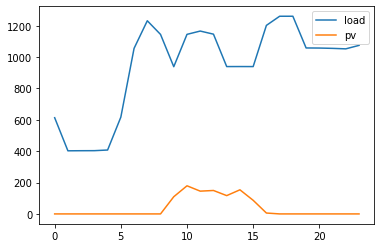

In [21]:
red.set_horizon(24)
plt.plot(red.forecast_load(), label='load')
plt.plot(red.forecast_pv(), label='pv')
plt.legend()
plt.show()

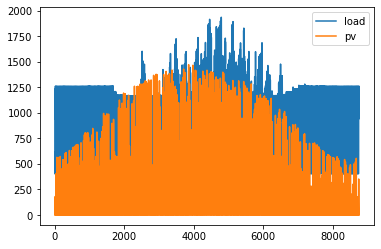

In [22]:
red.set_horizon(24*365)
plt.plot(red.forecast_load(), label='load')
plt.plot(red.forecast_pv(), label='pv')
plt.legend()
plt.show()

-457.79780942453147 1716.449979931014


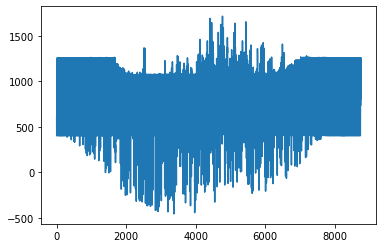

In [23]:
demanda_neta = red.forecast_load() - red.forecast_pv()
plt.plot(demanda_neta)
print(demanda_neta.min(), demanda_neta.max())

## Q Table

In [24]:
red.set_horizon(9000)
demanda_neta = red.forecast_load() - red.forecast_pv() 
demanda_neta.std()  

360.5230588793123

In [25]:
(demanda_neta > demanda_neta.mean() + 3 * demanda_neta.std()).sum()

0

In [26]:
demanda_neta.mean() - 3*demanda_neta.std()

-349.5166677861106

In [27]:
demanda_neta.min(), demanda_neta.max()

(-457.79780942453147, 1716.449979931014)

In [28]:
def init_qtable(red, nb_action):

    # Demanda neta en un horizonte de un año
    red.set_horizon(1000)
    demanda_neta = red.forecast_load() - red.forecast_pv()
    posible_demanda_min = demanda_neta.mean() - 3 * demanda_neta.std()
    posible_demanda_max = demanda_neta.mean() + 3 * demanda_neta.std()

    #creamos una lista que guardará todas las combinaciones de demanda_neta y estado de la batería
    state = []  
    for d_n in range(int(posible_demanda_min),int(posible_demanda_max+1)):  #ciclo entre la demanda neta minima y máxima DISCRETIZADA    
        for soc in np.arange(red.battery.soc_min, red.battery.soc_max + 0.1, 0.1):  #ciclo entre el estado de carga de la batería minima y máxima  DISCRETIZADO
            soc = round(soc, 1)
            state.append((d_n, soc))            
    Q={}
    #Iniciamos el estado Q(s,a) en cero
    for s in state:
        Q[s] = {}                            
        for a in range(nb_action):
            Q[s][a] = 0

    return Q

In [29]:
Q = init_qtable(red, 3)
print('Total de estados posibles:',len(Q))  

Total de estados posibles: 16524


In [30]:
# Si queremos podemos visualizarlo como tabla con pandas
import pandas as pd 
pd.DataFrame.from_dict(Q, orient='index' )

0  1  2
-106  0.2  0  0  0
      0.3  0  0  0
      0.4  0  0  0
      0.5  0  0  0
      0.6  0  0  0
...       .. .. ..
 1729 0.6  0  0  0
      0.7  0  0  0
      0.8  0  0  0
      0.9  0  0  0
      1.0  0  0  0

[16524 rows x 3 columns]

## Definición de las acciones

* accion 0: cargar batería
* accion 1: descargar batería
* acción 2: generación no renovable (genset)

In [31]:
red.get_control_dict()  # con este diccionario podemos interactuar con la microrred

['load',
 'pv_consummed',
 'pv_curtailed',
 'pv',
 'battery_charge',
 'battery_discharge',
 'genset']

In [32]:
# Estado actual
demanda_neta = red.load - red.pv
demanda_neta, red.battery.soc

(613.563907279512, 0.2)

In [33]:
# Acción decargar la batería
red.run({'pv_consumed': 0,               # equivalente a step()
         'battery_charge': 400,
         'battery_discharge':0,
         'genset': 0})

{'battery_soc': 0.2738158704121386,
 'capa_to_charge': 3935.111111111111,
 'capa_to_discharge': 324.0,
 'hour': 0,
 'load': 402.5395964491036,
 'pv': 0.0}

In [34]:
print(red.battery.soc) #estado de carga de la batería

0.2738158704121386


In [46]:
# accion 0: cargar batería
# accion 1: descargar batería
# acción 2: generación no renovable (genset)

def actions_agent(accion):

    #DEMANDA NETA       
    demanda_neta =  red.load - red.pv  # Reflexiona: ¿Qué significa que la demanda neta sea positiva?
                                       #              ¿ y negativa?
 

    capa_to_charge = red.battery.capa_to_charge  # cantidad de energía que la batería puede cargar antes de tener carga completa
    p_charge_max = red.battery.p_charge_max      # cantidad de energía máxima que puede cargar la batería en una hora
    p_charge = max(0, min(-demanda_neta, capa_to_charge, p_charge_max)) # energía que se puede cargar

    capa_to_discharge = red.battery.capa_to_discharge
    p_discharge_max = red.battery.p_discharge_max
    p_discharge = max(0, min(demanda_neta, capa_to_discharge, p_discharge_max)) # energía que se puede descargar


    control_dic ={}
    if accion == 0:   # Cargar batería
        control_dict= {'pv_consumed': min(red.pv, red.load),
                       'battery_charge': p_charge,
                       'battery_discharge': 0,
                       'genset': abs(min(0, red.pv - min(red.pv, red.load) - p_charge))
                       }
    elif accion == 1:   # Descargar bateria

        control_dict = {'pv_consummed': min(red.pv, red.load),
                        'battery_charge': 0,
                        'battery_discharge': p_discharge,
                        'genset': max(0, red.load - min(red.pv, red.load) - p_discharge)
                        }
   
    elif accion == 2:  #Generación no renovable (genset)
      
        control_dict = {'pv_consummed': min(red.pv, red.load),
                        'battery_charge': 0,
                        'battery_discharge': 0,
                        'genset': max(0, red.load - min(red.pv, red.load))
                       }


    return control_dict

# Estrategia descendiente codiciosa (Greedy decreasing strategy )

Programación dinámica

dilema explotacion-exploracion 

[Referencia](https://en.wikipedia.org/wiki/Multi-armed_bandit) 



In [38]:
def espilon_decreasing_greedy(action, epsilon, nb_action): 
  '''A partir de la acción de entrada, se decide si se sigue con la misma acción
  o se elige otra'''
  
  p = np.random.random()
  
  if p < (1 - epsilon):
        randomm = 0
        return action, randomm   # sigue con la misma acción y regresa 0 en randomm

  else: 
        randomm=1
        return np.random.choice(nb_action), randomm     # elige aleatoriamente una acción y regresa 1 en randomm

Función para diminuir y actualizar epsilon

In [39]:
def update_epsilon(epsilon):
  
    
    epsilon = epsilon - epsilon *0.01  #se cambión 0.2 por 0.1 para hacer más lento el descenso de epsilon
    
    if epsilon < 0.1:
        
        epsilon = 0.1
    
    return epsilon

In [40]:
def max_dict(d):

    max_key = None
    max_val = float('-inf')


    for k,v in d.items():

        if v > max_val:

            max_val = v
            max_key = k

    return max_key, max_val

In [41]:
def change_name_action(idx):
    
    # acción 0: cargar batería
    # acción 1: descargar batería
    # acción 2: generación no renovable (genset)

    
    if idx == 0:
        action_name = "carga"
    elif idx == 1:
        action_name = "descarga"
    else:
        action_name = "generación no renovable"
    
    return action_name

In [42]:
def print_welcome(idx):
    
    if idx == 0:
        print("------------------------------------")
        print("|             WELCOME              |")
        print("------------------------------------")
    elif idx == 1:
        
        print("t -     STATE  -  ACTION - COST")
        print("================================")
    

# Función del Agente


In [50]:
def training_Q_Learning(mg,horizon):

    nb_action = 3                             #total de acciones
    Q = init_qtable(mg, nb_action)    #inicializar tabla de estados
    nb_state = len(Q)         #episodio
    nb_episode = 100
    alpha = 0.1        
    epsilon = 0.99
    gamma = 0.99

    #   Q[s][a] += alpha*(r - Q[s][a])  
    
    record_cost = []     # función de pérdida
    t0 = time.time()
    t = t0
    print_training = "Training Progressing .   "
    print_welcome(0)  
    print("\n")
    

    for e in range(nb_episode+1):  
        # Control del prgreso del entrenamiento   #############################
        if e == 0:
            value_print="\rEpisode " + str(e) +"/" + str(nb_episode)   
            sys.stdout.write(value_print)   
            sys.stdout.flush( )              
        else:      
            now = time.time()
            if e == 1 or e == 50 or e == 100 or e == 200 or e == 300 or e == 400  or e == 450  or e == 485 or e == nb_episode-5:
                diff_time_t = now - t 
                total_time = (nb_episode+1) * diff_time_t           
            now = time.time()           
            diff_time = now - t0
            time_remaining = total_time - diff_time           
            t = time.time()
        if e % 10 == 0:       
            if print_training == "Training Progressing .   ":                
                print_training = "Training Progressing ..  "                
            elif print_training == "Training Progressing ..  ":            
                print_training = "Training Progressing ... "           
            else:            
                print_training = "Training Progressing .   "

        value_print="\r"+ print_training +"Episode " + str(e) +"/" + str(nb_episode) 
        sys.stdout.write(value_print) 
        sys.stdout.flush()   
        ###########################################################################    
        episode_cost = 0                  # Costo
        mg.reset()
        
        # Calcula las variables de estado
        net_load = round(mg.load - mg.pv)
        soc = round(mg.battery.soc,1)
        s = (net_load, soc)
        a = max_dict(Q[s])[0]    # Escoje la accion con el valor más grande del diccionario Q
        a, randomm = espilon_decreasing_greedy(a, epsilon, nb_action)  #estrategia de gradiente codicioso
               
        for i in range (horizon):
            
            action = actions_agent(a)         # a partir de la acción elegida, se obtiene el diccionario de control para modificar la red
            status = mg.run(action)           # run es equivalente a step() en OpenAI Gym pero toma por argumento el diccionario de control
            r = -mg.get_cost()                # guarda el costo de esa acción
            episode_cost += mg.get_cost()     #lo suma al costo del episodio 
            net_load = round(mg.load - mg.pv)
            soc = round(mg.battery.soc,1)
            s_ = (net_load, soc)              # guarda el estado
            a_ = max_dict(Q[s_])[0]           # escoje la clave con el valor más grande del diccionario Q  ERROR
            
            if i == horizon-1:  
                
                Q[s][a] += alpha*(r - Q[s][a])    
      
            else:
             
                old_Q = Q[s][a]
                target = r + gamma*Q[s_][a_]
                td_error = target - Q[s][a]
                Q[s][a] = (1-alpha) * Q[s][a] + alpha * td_error
                
            s, a = s_, a_
       
        epsilon = update_epsilon(epsilon)
        
    return Q

In [51]:
 Q1 = training_Q_Learning(red,7000)

------------------------------------
|             WELCOME              |
------------------------------------


Training Progressing ... Episode 100/100

In [62]:
politica = pd.DataFrame.from_dict(Q1, orient='index' )
politica.columns=['accion_0', 'accion_1','accion_2']

In [64]:
politica[politica['accion_2']!=0]

,,accion_0,accion_1,accion_2
-458,0.2,-1418.841636,-30.050003,-30.015650
-444,0.2,-1465.792629,-40.668992,-40.664658
-434,0.2,-1405.981957,-49.087873,-49.086066
-431,0.2,-1377.502142,-14.856332,-14.849091
-420,0.2,-1367.516475,-117.041094,-117.042224
...,...,...,...,...
1642,0.2,-1677.098178,-954.857434,-954.874241
1646,0.2,-1645.914709,-895.066797,-895.079406
1655,0.2,-1654.856770,-930.966711,-930.985355
1693,0.2,-1692.720452,-924.557802,-924.567371


In [57]:
def testing_Q_Learning(mg, Q, horizon):
    
    mg.reset()
    net_load = round(mg.load - mg.pv)
    soc = round(mg.battery.soc,1)
    s = (net_load, soc)
    a = max_dict(Q[s])[0]
    total_cost = 0
    print_welcome(1)
    for i in range (horizon):

        action_name = change_name_action(a)
        action = actions_agent(a)
        status = mg.run(action)
        cost = mg.get_cost()
        total_cost += cost
        if i < 10:
            print(i," -",(int(net_load),soc),action_name, round(total_cost,1), "$")
        else:
            print(i,"-",(int(net_load),soc),action_name, round(total_cost,1), "$")
        net_load = round(mg.load - mg.pv)
        soc = round(mg.battery.soc,1)
        s_ = (net_load, soc)
        a_ = max_dict(Q[s_])[0]

        s, a = s_, a_

In [55]:
testing_Q_Learning(red,Q1, 7960)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
2960 - (334, 0.2) descarga 1297842.2 $
2961 - (304, 0.2) generación no renovable 1298024.6 $
2962 - (403, 0.2) descarga 1298266.5 $
2963 - (86, 0.2) descarga 1298352.7 $
2964 - (-124, 0.2) descarga 1298352.7 $
2965 - (278, 0.2) descarga 1298519.5 $
2966 - (-44, 0.2) descarga 1298519.5 $
2967 - (522, 0.2) generación no renovable 1298832.5 $
2968 - (778, 0.2) generación no renovable 1299299.2 $
2969 - (1086, 0.2) generación no renovable 1299950.8 $
2970 - (921, 0.2) descarga 1300503.3 $
2971 - (1064, 0.2) generación no renovable 1301141.7 $
2972 - (1061, 0.2) descarga 1301778.3 $
2973 - (1057, 0.2) generación no renovable 1302412.7 $
2974 - (1078, 0.2) generación no renovable 1303059.2 $
2975 - (618, 0.2) generación no renovable 1303429.8 $
2976 - (406, 0.2) descarga 1303673.7 $
2977 - (407, 0.2) generación no renovable 1303918.0 $
2978 - (407, 0.2) generación no renovable 1304162.4 $
2979 - (425, 0.2) generación no renov